In [5]:
import requests
import nltk, re, pprint, io, json
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
def build_query_url(page):
    # Build query
    queryUrl = "http://en.wikipedia.org/w/api.php/?action=query"
    title = "titles=%s" % page 
    content = "prop=extracts&exlimit=max&explaintext"
    dataformat = "format=json"
    query = "%s&%s&%s&%s" % (queryUrl, title, content, dataformat)
    return query

def get_content(url):
    # Send request and parse response
    json_response = requests.get(url).json()
    pages = json_response['query']['pages']
    key = next(iter(pages.keys()))
    content = pages[key]['extract']
    return content
    
def fetch_content(page):
    url = build_query_url(page)
    content = get_content(url)
    return content

def save_to_file(content, page_name):
    filename = 'congress115/%s.txt' % page_name
    f = open(filename, "a")
    f.write(content)
    f.close()  

In [6]:
# Create a dataframe which contains page names for the 115th congress
url_h115 = 'https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_US_congress/H115.csv'
df = pd.read_csv(url_h115)
page_names = df.WikiPageName

In [ ]:
%%time
# Fetch each wikipage and save to a txt file
for page_name in page_names:
    content = fetch_content(page_name)
    save_to_file(content, page_name)

## Exercises
### TF-IDF
**Explain in your own words the point of TF-IDF.**
* What does TF stand for?
* What does IDF stand for?

Answer:
* TFIDF (term frequency–inverse document frequency), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. Tf–idf is one of the most popular term-weighting schemes today.

* Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

### Tokenizing the Wikipedia Pages
We want to find out which words are important for each party, so we're going to create two large documents, one for the Democratic and one for the Republican party. Tokenize the pages, and combine the tokens into one long list including all the pages of the members of the same party. Remember the bullets below for success.
* Exclude the congress members names (since we're interested in the words, not the names).
* Exclude punctuation.
* Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
* Exclude numbers (since they're difficult to interpret in the word cloud).
* Set everything to lower case.

*Note that none of the above has to be perfect. It might not be easy to remove all representatives names. And there's some room for improvisation. You can try using stemming. In my own first run the results didn't look so nice, because some pages are very detailed and repeat certain words again and again and again, whereas other pages are very short. For that reason, I decided to use the unique set of words from each page rather than each word in proportion to how it's actually used on that page. Choices like that are up to you.
Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each party.*

In [3]:
from nltk.corpus import stopwords
import string

In [48]:
name_tokens = " ".join(page_names)
name_tokens = nltk.word_tokenize(name_tokens)
name_tokens = " ".join(name_tokens).replace("_", " ").replace("politician", "").lower()
name_tokens = re.findall(r'\w+', name_tokens)

In [66]:
def clean_document(doc, bad_words):    
    doc = doc.lower()
    tokens = re.findall(r'[a-zA-Z]', doc) 
    tokens = [t for t in tokens if t not in bad_words]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return tokens  

In [67]:
def build_document(party):
    doc = ""
    names = df[df.Party == party].WikiPageName
    for name in names:
        page = io.open('congress115/%s.txt' % name, 'r').read()
        doc += page + " "
    return doc

In [68]:
repub_doc = build_document("Republican")
demo_doc = build_document("Democratic")

In [69]:
repub_tokens = clean_document(repub_doc, name_tokens)
demo_tokens = clean_document(demo_doc, name_tokens)

In [70]:
import pickle
output = open('repub_tokens.obj', 'wb')
pickle.dump(repub_tokens, output)
output.close()

output = open('demo_tokens.obj', 'wb')
pickle.dump(demo_tokens, output)
output.close()

* Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each party.

For TF I will be using the simplest variation, i.e. just the frequency of the word.

$tf(t,d) = f_{t,d}$

In [71]:
repub_fd = nltk.FreqDist(repub_tokens)
demo_fd = nltk.FreqDist(demo_tokens)

In [73]:
demo_fd.most_common(10)

[('house', 1960),
 ('district', 1590),
 ('election', 1518),
 ('congress', 1505),
 ('congressional', 1490),
 ('democratic', 1351),
 ('caucus', 1289),
 ('committee', 1251),
 ('u', 1177),
 ('states', 1166)]

In [75]:
# Extracting TF's
TF_repub = list(
    map(lambda tup: tup[1], repub_fd.most_common())
)

TF_demo = list(
    map(lambda tup: tup[1], demo_fd.most_common())
)

* Next, we calculate IDF for every word.
  * What base logarithm did you use? Is that important?
    * Log 10, no it does not matter for this purpose, since we just wish for there to an inverse exponential relationship, where a word that appears in all documents have an IDF value of 0
  
$idf(t,D) = log \left( \frac{N}{df_t} \right)$

In [76]:
repub_tokens_ordered = list(
    map(lambda tup: tup[0], repub_fd.most_common())
)

demo_tokens_ordered = list(
    map(lambda tup: tup[0], demo_fd.most_common())
)

In [77]:
output = open('repub_tokens_ordered.obj', 'wb')
pickle.dump(repub_tokens_ordered, output)
output.close()

output = open('demo_tokens_ordered.obj', 'wb')
pickle.dump(demo_tokens_ordered, output)
output.close()

In [78]:
repub_tokens_set = set(repub_tokens)
demo_tokens_set = set(demo_tokens)

In [79]:
import numpy as np

In [80]:
N_repub = len(repub_tokens_ordered)
DF_repub = np.zeros(N_repub)

for i, t in enumerate(repub_tokens_ordered):
    DF_repub[i] += (t in repub_tokens_set) + (t in demo_tokens_set)

In [81]:
N_demo = len(demo_tokens_ordered)
DF_demo = np.zeros(N_demo)

for i, t in enumerate(demo_tokens_ordered):
    DF_demo[i] += (t in repub_tokens_set) + (t in demo_tokens_set)

In [95]:
# Calculate IDFs
N = 2
IDF_repub = np.log(N / DF_repub)
IDF_demo = np.log(N / DF_demo)

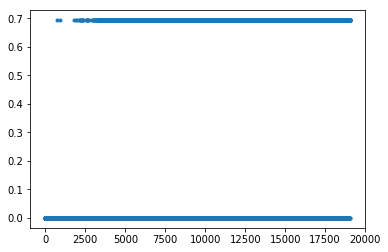

In [96]:
plt.plot(IDF_repub, ".")
plt.show()

**Calculating $TF \cdot IDF$**

In [101]:
TFIDF_repub = np.zeros(N_repub)
for i in range(N_repub):
    TFIDF_repub[i] = TF_repub[i] * IDF_repub[i]

In [100]:
TFIDF_demo = np.zeros(N_demo)
for i in range(N_demo):
    TFIDF_demo[i] = TF_demo[i] * IDF_demo[i]

In [102]:
np.save("TFIDF_repub", TFIDF_repub)
np.save("TFIDF_demo", TFIDF_demo)